# Classical ML Modeling

This file represents me building classical ML models for the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pyarrow
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import sys

sys.path.append('../src')
from metricsLogger import MLMetricsLogger

%matplotlib inline

In [2]:
# Getting the data
training_data = pd.read_parquet('../data/train.parquet',engine='pyarrow')
validation_data = pd.read_parquet('../data/valid.parquet',engine='pyarrow')

In [3]:
# Viewing the data shapes to make sure everything is loaded correctly
training_data.shape, validation_data.shape

((8015, 10001), (14409, 10001))

In [4]:
# Splitting the data into features and target
X_train, y_train = training_data.drop('label', axis=1), training_data['label']
X_valid, y_valid = validation_data.drop('label', axis=1), validation_data['label']

In [5]:
# Checking the statistics for the pixels
X_train.iloc[:,9990:10000].describe()

,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
count,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000
mean,0.269576,0.190374,0.118911,0.107272,0.098846,0.083768,0.083441,0.103348,0.074237,0.095866
std,0.203952,0.135341,0.086047,0.045402,0.062408,0.064253,0.057867,0.090961,0.050083,0.063028
min,0.027451,0.023529,0.023529,0.023529,0.019608,0.019608,0.019608,0.023529,0.019608,0.023529
25%,0.082353,0.078431,0.058824,0.070588,0.054902,0.043137,0.039216,0.039216,0.039216,0.054902
50%,0.196078,0.149020,0.094118,0.101961,0.074510,0.058824,0.070588,0.066667,0.058824,0.082353
75%,0.466667,0.290196,0.141176,0.137255,0.129412,0.098039,0.101961,0.133333,0.101961,0.119608
max,0.803922,0.749020,0.600000,0.862745,0.937255,0.917647,0.878431,0.862745,0.894118,0.933333


## Preprocessing 

In [6]:
# Doing PCA to reduce the number of features
if not os.path.exists('../models/pca.pkl'):
    pca = PCA(n_components=0.95,random_state=42)
    print('Fitting PCA')
    X_train_pca = pca.fit_transform(X_train)
    print('Transforming validation data')
    X_valid_pca = pca.transform(X_valid)
    print('Saving PCA model')
    joblib.dump(pca, '../models/pca.pkl')
    print('PCA model saved')
else:
    pca = joblib.load('../models/pca.pkl')
    X_train_pca = pca.transform(X_train)
    X_valid_pca = pca.transform(X_valid)

In [7]:
# Getting the reduced shapes
X_train_pca.shape, X_valid_pca.shape

((8015, 196), (14409, 196))

In [8]:
# Comparing to original shapes
X_train.shape, X_valid.shape

((8015, 10000), (14409, 10000))

Label:  talking on the phone - right


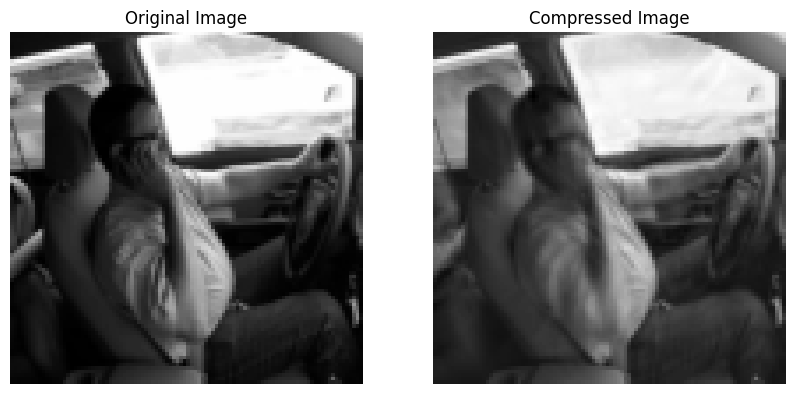

In [9]:
# Printing the data prior to compression
height = 100
width = 100
random_image = np.random.randint(0, X_train.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X_train.iloc[random_image].values.reshape(height, width), cmap='gray')
ax1.axis('off')
ax1.set_title('Original Image')

# Plotting the compressed image
ax2.imshow(pca.inverse_transform(X_train_pca[random_image]).reshape(height, width), cmap='gray')
ax2.axis('off')
ax2.set_title('Compressed Image')
labels_to_names = {0: 'safe driving',1: 'texting - right', 2: 'talking on the phone - right', 
                   3: 'texting - left', 4: 'talking on the phone - left', 5: 'operating the radio', 
                   6: 'drinking', 7: 'reaching behind', 8: 'hair and makeup', 9: 'talking to passenger'}
print('Label: ', labels_to_names[y_train.iloc[random_image]])
plt.show()

## Modeling

In [10]:
# Setting up the logger object
logger = MLMetricsLogger()

### Logistic Regression

In [11]:
logistic_model = LogisticRegression(penalty='l2',C=0.15,random_state=42,solver='sag',max_iter=100,multi_class='multinomial',verbose=50,tol=1e-3)
logistic_model.fit(X_train_pca, y_train)
joblib.dump(logistic_model, '../models/model_2.pkl')

/Users/jinalshah/.pyenv/versions/3.9.18/envs/distracted-driver-prediction/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 2, change: 0.19848594
Epoch 3, change: 0.15506618
Epoch 4, change: 0.09138499
Epoch 5, change: 0.09881829
Epoch 6, change: 0.04564834
Epoch 7, change: 0.04096283
Epoch 8, change: 0.03388669
Epoch 9, change: 0.01915784
Epoch 10, change: 0.01793986
Epoch 11, change: 0.01240699
Epoch 12, change: 0.01061368
Epoch 13, change: 0.00967559
Epoch 14, change: 0.00831772
Epoch 15, change: 0.00778717
Epoch 16, change: 0.00724970
Epoch 17, change: 0.00673624
Epoch 18, change: 0.00643634
Epoch 19, change: 0.00612863
Epoch 20, change: 0.00584622
Epoch 21, change: 0.00558979
Epoch 22, change: 0.00524710
Epoch 23, change: 0.00501634
Epoch 24, change: 0.00484817
Epoch 25, change: 0.00458812
Epoch 26, change: 0.00441385
Epoch 27, change: 0.00422307
Epoch 28, change: 0.00393287
Epoch 29, change: 0.00378849
Epoch 30, change: 0.00360642
Epoch 31, change: 0.00344884
Epoch 32, change: 0.00328524
Epoch 33, change: 0.00325158
Epoch 34, change: 0.00296575
Epoch 35, change: 0.002

['../models/model_2.pkl']

In [12]:
# Making predictions
y_train_pred = logistic_model.predict_proba(X_train_pca)
y_valid_pred = logistic_model.predict_proba(X_valid_pca)

In [13]:
# Checking the metrics
metrics = logger.calculate_metrics("2",'Logistic Regression',y_train,y_train_pred,y_valid,y_valid_pred)
metrics

{'model_id': '2',
 'model_name': 'Logistic Regression',
 'train_CE_loss': 0.018539669314360147,
 'train_acc': 0.9998752339363693,
 'validation_CE_loss': 3.911086036072996,
 'validation_acc': 0.2644180720383094}

In [14]:
# Logging the metrics
try:
    logger.log_metrics(metrics)
except Exception as e:
    print('Already logged')

### Decision Trees

In [15]:
d_tree = DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=12,max_features='sqrt')
d_tree.fit(X_train_pca, y_train)
joblib.dump(d_tree, '../models/model_3.pkl')

['../models/model_3.pkl']

In [16]:
# Making predictions
y_train_pred = d_tree.predict_proba(X_train_pca)
y_valid_pred = d_tree.predict_proba(X_valid_pca)

In [17]:
# Checking the metrics
metrics = logger.calculate_metrics("3",'Decision Tree',y_train,y_train_pred,y_valid,y_valid_pred)
metrics

{'model_id': '3',
 'model_name': 'Decision Tree',
 'train_CE_loss': 0.24203798034815044,
 'train_acc': 0.9206487835308796,
 'validation_CE_loss': 26.39875220745922,
 'validation_acc': 0.1778749392740648}

In [18]:
# Logging the metrics
try:
    logger.log_metrics(metrics)
except Exception as e:
    print('Already logged')

### Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=100,criterion='gini',bootstrap=True,random_state=42)
rf.fit(X_train_pca, y_train)
joblib.dump(rf, '../models/model_4.pkl')

['../models/model_4.pkl']

In [20]:
# Making predictions
y_train_pred = rf.predict_proba(X_train_pca)
y_valid_pred = rf.predict_proba(X_valid_pca)

In [21]:
# Checking the metrics
metrics = logger.calculate_metrics("4",'Random Forest',y_train,y_train_pred,y_valid,y_valid_pred)
metrics

{'model_id': '4',
 'model_name': 'Random Forest',
 'train_CE_loss': 0.08807704745257257,
 'train_acc': 1.0,
 'validation_CE_loss': 2.2754440711585193,
 'validation_acc': 0.24533277812478313}

In [22]:
# Running GridSearch because the metrics for RF weren't too bad
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [7,10, 12],
}
search = GridSearchCV(estimator=RandomForestClassifier(criterion='gini',bootstrap=True,random_state=42),
                      param_grid=param_grid,scoring='neg_log_loss',refit=True,cv=3,verbose=3,return_train_score=True)
search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_depth=7, n_estimators=50;, score=(train=-0.766, test=-1.947) total time=   6.9s
[CV 2/3] END max_depth=7, n_estimators=50;, score=(train=-0.814, test=-1.790) total time=   6.8s
[CV 3/3] END max_depth=7, n_estimators=50;, score=(train=-0.708, test=-2.048) total time=   6.3s
[CV 1/3] END max_depth=7, n_estimators=100;, score=(train=-0.745, test=-1.934) total time=  13.2s
[CV 2/3] END max_depth=7, n_estimators=100;, score=(train=-0.800, test=-1.771) total time=  16.1s
[CV 3/3] END max_depth=7, n_estimators=100;, score=(train=-0.702, test=-2.030) total time=  13.1s
[CV 1/3] END max_depth=7, n_estimators=150;, score=(train=-0.745, test=-1.924) total time=  21.9s
[CV 2/3] END max_depth=7, n_estimators=150;, score=(train=-0.798, test=-1.777) total time=  24.4s
[CV 3/3] END max_depth=7, n_estimators=150;, score=(train=-0.714, test=-2.037) total time=  24.4s
[CV 1/3] END max_depth=10, n_estimators=50;, score=(train=-0.

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [7, 10, 12],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_log_loss', verbose=3)

In [23]:
best_rf = search.best_estimator_
joblib.dump(best_rf, '../models/model_5.pkl')

y_train_pred = best_rf.predict_proba(X_train_pca)
y_valid_pred = best_rf.predict_proba(X_valid_pca)

In [24]:
# Checking the metrics
metrics_2 = logger.calculate_metrics("5",'Random Forest -- GridSearch',y_train,y_train_pred,y_valid,y_valid_pred)
metrics_2

{'model_id': '5',
 'model_name': 'Random Forest -- GridSearch',
 'train_CE_loss': 0.270310444280272,
 'train_acc': 1.0,
 'validation_CE_loss': 2.1575463907205834,
 'validation_acc': 0.26247484211256855}

In [25]:
# Logging both models
try:
    logger.log_metrics(metrics)
    logger.log_metrics(metrics_2)
except Exception as e:
    print('Already logged')

### Gradient Boosting (CatBoost)

https://randomrealizations.com/posts/gradient-boosting-multi-class-classification-from-scratch/#prediction 

In [26]:
params = {
    'iterations':1000,
    'learning_rate':0.01,
    'loss_function':'MultiClass',
    'custom_metric':'Accuracy',
    'eval_metric':'MultiClass',
    'random_seed':42,
    'early_stopping_rounds':5,
    'use_best_model':True,
}
catboost_clf = CatBoostClassifier(**params)
catboost_clf.fit(X_train_pca, y_train,eval_set=(X_valid_pca, y_valid),verbose=50)

# Saving the model
catboost_clf.save_model('../models/model_6.cbm')

0:	learn: 2.2854753	test: 2.2997365	best: 2.2997365 (0)	total: 1.39s	remaining: 23m 8s
50:	learn: 1.6760259	test: 2.2324926	best: 2.2324926 (50)	total: 56.2s	remaining: 17m 25s
100:	learn: 1.3178105	test: 2.2119088	best: 2.2119088 (100)	total: 1m 49s	remaining: 16m 17s
150:	learn: 1.0692341	test: 2.1993202	best: 2.1993202 (150)	total: 2m 41s	remaining: 15m 5s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 2.199320226
bestIteration = 150

Shrink model to first 151 iterations.


In [27]:
# Checking tree count
catboost_clf.tree_count_

151

In [29]:
y_train_pred = catboost_clf.predict_proba(X_train_pca,ntree_end=catboost_clf.tree_count_)
y_valid_pred = catboost_clf.predict_proba(X_valid_pca,ntree_end=catboost_clf.tree_count_)

In [30]:
# Checking the metrics
metrics = logger.calculate_metrics("6",'Catboost',y_train,y_train_pred,y_valid,y_valid_pred)
metrics

{'model_id': '6',
 'model_name': 'Catboost',
 'train_CE_loss': 1.069234061176899,
 'train_acc': 0.9287585776668746,
 'validation_CE_loss': 2.199320226235013,
 'validation_acc': 0.22902352696231523}

In [31]:
# Logging both models
try:
    logger.log_metrics(metrics)
except Exception as e:
    print('Already logged')

## Analysis

In [32]:
# Reading the metrics
metrics_df = pd.DataFrame(logger.read_metrics())
metrics_df

,model_id,model_name,train_CE_loss,validation_CE_loss,train_acc,validation_acc
0,1,Baseline Model (Random Classifer),2.7292835997275806,2.7133451340303605,0.09794135995009358,0.10264418072038309
1,2,Logistic Regression,0.018539669314360147,3.911086036072996,0.9998752339363693,0.2644180720383094
2,3,Decision Tree,0.24203798034815044,26.39875220745922,0.9206487835308796,0.1778749392740648
3,4,Random Forest,0.08807704745257257,2.2754440711585193,1.0,0.24533277812478313
4,5,Random Forest -- GridSearch,0.270310444280272,2.1575463907205834,1.0,0.26247484211256855
5,6,Catboost,1.069234061176899,2.199320226235013,0.9287585776668746,0.22902352696231523
